In [15]:
# Import libraries.
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

In [16]:
# Prepare the dataloaders for the MNIST and SVHN datasets.
def get_loader():   
    transform = transforms.Compose([
                    transforms.Resize(32),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))]) # Specift the transformations that must be applied.
    svhn = datasets.SVHN(root='./svhn', download=True, transform=transform)
    mnist = datasets.MNIST(root='./mnist', download=True, transform=transform)
    svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                              batch_size=64,
                                              shuffle=True,
                                              num_workers=2)
    mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                               batch_size=64,
                                               shuffle=True,
                                               num_workers=2)
    return svhn_loader, mnist_loader

In [23]:
# Calculate the mean and the standard deviation.
def get_mean_std(input, eps=1e-5):
  batch_size, channels = input.shape[:2]
  reshaped = input.view(batch_size, channels, -1) # Reshape the input channel-wise.
  mean = torch.mean(reshaped, dim = 2).view(batch_size, channels, 1, 1)  # Get the mean.
  std = torch.sqrt(torch.var(reshaped, dim=2)+eps).view(batch_size, channels, 1, 1) # Get the standard deviation.
  return mean, std

# Calculate the mean square error for the content loss.
def get_content_loss(input, target): 
  loss = F.mse_loss(input, target)
  return loss

# Calculate the mean square errors for the style loss.
def get_style_loss(input, target):
  mean_loss, std_loss = 0, 0
  for input_layer, target_layer in zip(input, target): 
    mean_input_layer, std_input_layer = get_mean_std(input_layer)
    mean_target_layer, std_target_layer = get_mean_std(target_layer)
    mean_loss += F.mse_loss(mean_input_layer, mean_target_layer)
    std_loss += F.mse_loss(std_input_layer, std_target_layer)
  return mean_loss+std_loss
  
# Perform Adaptive Instance Normalization.
def AdaIn(content, style):
  assert content.shape[:2] == style.shape[:2] 
  batch_size, n_channels = content.shape[:2]
  mean_content, std_content = get_mean_std(content) 
  mean_style, std_style = get_mean_std(style)
  output = std_style*((content - mean_content) / (std_content)) + mean_style # Huang, X. & Belongie S. (5)
  return output



In [24]:
# Merge the images to display the results.  
def merge_images(self, sources, targets):
  _, _, h, w = sources.shape
  row = int(np.sqrt(self.batch_size))
  merged = np.zeros([3, row*h, row*w*2])
  for idx, (s, t) in enumerate(zip(sources, targets)):
      i = idx // row
      j = idx % row
      merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
      merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
  return merged.transpose(1, 2, 0)

In [25]:
# Build the encoder for the CNN AE that is replacing the VGG.
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_0 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv_1 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv_2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv_3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
    def forward(self, x): 
        x = F.relu(self.conv_0(x))
        x = self.pool(x)
        x = F.relu(self.conv_1(x))
        x = self.pool(x)
        x = F.relu(self.conv_2(x))
        x = self.pool(x)
        x = F.relu(self.conv_3(x))
        x = self.pool(x)     
        return x
encoder = Encoder()

In [26]:
# Build a decoder for the CNN AE that is replacing the VGG.
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_0_3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv_1_2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv_2_1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv_3_0 = nn.Conv2d(16, 3, 2, stride=2)
    def forward(self, x): 
        x = F.relu(self.conv_0_3(x))
        x = F.relu(self.conv_1_2(x))
        x = F.relu(self.conv_2_1(x))
        x = F.sigmoid(self.conv_3_0(x))    
        return x

decoder = Decoder()

In [27]:
# Build the style transfer network.
class StyleTransferNetwork(nn.Module):
  def __init__(self, learning_rate=1e-4, learning_rate_decay=5e-5, gamma=2.0, train=True):
    super().__init__()
    self.learning_rate = learning_rate
    self.learning_rate_decay = learning_rate_decay
    self.gamma = gamma # loss = gamma * style_loss + content_loss
    self.train = train 
    self.encoder = Encoder() 
    self.decoder = Decoder()
    self.optimiser = optim.Adam(self.decoder.parameters(), lr=self.learning_rate) # An Adam optimizer is used to replicate Huang and Belongie's paper.
    self.iterations = 0

  # Change the status of the network, wether it is training or not.
  def set_train(self, boolean):
    assert type(boolean) == bool
    self.train = boolean

  # Set the learning rate decay.
  def adjust_learning_rate(self, optimiser, iterations):
    lr = learning_rate / (1.0 + learning_rate_decay * iterations)
    for param_group in optimiser.param_groups:
        param_group['lr'] = lr

  def forward(self, style, content, alpha=1.0):
    # Encode the style and the content.
    layers_style = self.encoder(style, self.train) 
    layer_content = self.encoder(content, False) 
    if self.train:
      style_applied = AdaIn(layer_content, layers_style[-1]) # The last layer is the style layer.
    else:
      style_applied = alpha*AdaIn(layer_content, layers_style) + (1-alpha)*layer_content # Change alpha to control the magnitude of the style.
    style_applied_upscaled = self.decoder(style_applied)
    if not self.train:
      return style_applied_upscaled 
    layers_style_applied = self.encoder(style_applied_upscaled, self.train)
    content_loss = get_content_loss(layers_style_applied[-1], layer_content) # Get the content loss.
    style_loss = get_style_loss(layers_style_applied, layers_style) # Get the style loss.
    loss_comb = content_loss + self.gamma*style_loss # Get the combined loss.
    return loss_comb, content_loss, style_loss


In [28]:
# Set the parameters.
learning_rate = 1e-4
learning_rate_decay = 5e-5
svhn_loader, mnist_loader = get_loader()
dataloader_comb = torch.utils.data.ConcatDataset([svhn_loader, mnist_loader]) 
dataloader_comb = get_loader()
gamma = torch.tensor([2])
epochs = 10
run_dir = "./AdaIN" 
network = StyleTransferNetwork(learning_rate, learning_rate_decay, gamma)

Using downloaded and verified file: ./svhn/train_32x32.mat
Using downloaded and verified file: ./svhn/train_32x32.mat


In [10]:
# Train the style transfer network.
def training_loop(network, dataloader_comb, epochs, run_dir):
  writer = SummaryWriter(run_dir)
  # Get the fixed images that will be compared over time.
  svhn_iter = iter(svhn_loader)
  mnist_iter = iter(mnist_loader)
  fixed_batch_content = (mnist_iter.next()[0])
  fixed_batch_style = (svhn_iter.next()[0])
  fixed_batch_style, fixed_batch_content =  fixed_batch_style.unsqueeze(0), fixed_batch_content.unsqueeze(0) 
  writer.add_image("Style", torchvision.utils.make_grid(fixed_batch_style))
  writer.add_image("Content", torchvision.utils.make_grid(fixed_batch_content))
  iters = network.iterations
  for epoch in range(1, epochs+1):
    for style_imgs, content_imgs in iter(dataloader):
      network.adjust_learning_rate(network.optimiser, iters)
      loss_comb, content_loss, style_loss = network(style_imgs, content_imgs) # Get the combines loss, content loss, and style loss.
      network.optimiser.zero_grad()
      loss_comb.backward()
      network.optimiser.step()
      if (iters+1) % 2000 == 1:
          images = merge_images(network(fixed_batch_style, fixed_batch_content))
          path = os.path.join(path, 'mnist-svhn.png')
          save_state(network.decoder.state_dict(), network.optimiser.state_dict(), iters, run_dir)
          writer.close()
          writer = SummaryWriter(os.path.join(path, run_dir))
      iters += 1
  print("Training has completed.")


In [ ]:
training_loop(network, dataloader_comb, epochs, run_dir)

Training has completed.


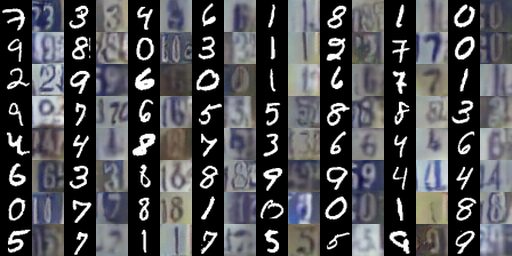

In [11]:
# Display the result of the style transfer.
out = os.path.join(run_dir, 'mnist-svhn.png')
out = torchvision.utils.make_grid(out.clamp(min=-1, max=1), nrow=3, scale_each=True, normalize=True)
mnist_svhn = toPIL(out)
mnist_svhn 